In [1]:
import os,sys
from tqdm import tqdm
import pickle

sys.path.append(os.getcwd().replace('/notebooks','/src'))

import torch
from models.DNN import NN
from dataset_utils import H5DatasetDNN, split_dataset
from utils.torch_utils import MARELoss, train

from matplotlib import pyplot as plt

### Define the model parameters:
-  **EPOCHS**: Number of epochs to be used for training the model
-  **TRAIN_BATCH_SIZE**: Batch size
-  **LAYERS**: A list which includes the number of nodes in each layer of the DNN starting with the input layer and ending with the output layer
-  **LRATE**: Learning rate
-  **TRAINING_FOLDER**: Folder to store the model summary and weights after every epoch

In [2]:
EPOCHS = 50
TRAIN_BATCH_SIZE = 1000
LAYERS = [28, 40, 1] # shape of DNN
LRATE = 1e-3 # learning rate
TRAINING_FOLDER="../training/test"

In [3]:
# create a directory if it doesn't exist
if not os.path.exists(TRAINING_FOLDER):
    os.system('mkdir -p {}'.format(TRAINING_FOLDER))

### Loading Dataset:
Use the custom H5DatasetDNN dataloader and split the dataset into two categories for training and testing. The dataset can be also converted to the pickle format and one can use PklDatasetDNN class instead. One can also write a custom function and add it dataset_utils.py file.

In [4]:
file_path = '../data/hgcal_electron_data_test.h5'
dataset = H5DatasetDNN(file_path)
train_test_datasets = split_dataset(dataset)

X = train_test_datasets['train']
Y = train_test_datasets['test']

dataloaders = { 'train': torch.utils.data.DataLoader(X, TRAIN_BATCH_SIZE, shuffle=True),
                'test': torch.utils.data.DataLoader(Y, len(Y), shuffle=True)}

Run the training and add losses and learning rates to a list which can then be saved as a pickle file.

In [5]:
nn = NN(LAYERS)
optimizer = torch.optim.Adam(nn.parameters(), lr = LRATE)
loss_func = torch.nn.MSELoss()

epochs = []
lr_array = []
train_loss_array = []
valid_loss_array = []

pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    train_loss = 0
    test_loss = 0
    for xtrain, ytrain in dataloaders['train']:
        tmptl, tmpto = train(nn, xtrain, ytrain, optimizer, loss_func)
        train_loss += tmptl.item()
    train_loss = train_loss/len(X)
        
    with torch.no_grad():
        for xtest, ytest in dataloaders['test']:
            xtest = nn(xtest).reshape(-1)
            tmpvl = loss_func(xtest, ytest)
            test_loss += tmpvl.item()
        test_loss = test_loss/len(Y)
            
    epochs.append(epoch)
    train_loss_array.append(train_loss)
    valid_loss_array.append(test_loss)
    lr_array.append(optimizer.param_groups[0]['lr'])

    pbar.set_postfix({'training loss': train_loss, 'validation loss': test_loss})
    torch.save(nn.state_dict(), f'{TRAINING_FOLDER}/epoch{epoch}')

training_summary = {
    'epochs': epochs,
    'train_loss': train_loss_array,
    'valid_loss': valid_loss_array,
    'learning_rate': lr_array
}

with open('{}/summary.pkl'.format(TRAINING_FOLDER),'wb') as f_:
    pickle.dump(training_summary, f_)

------- Initializing DNN -------
Input layer size:  28
Number of hidden layers :  3
Hidden layer 1 size: 40
Output layer size:  1
-------------------------------


100%|██████████| 50/50 [00:34<00:00,  1.45it/s, training loss=0.0102, validation loss=0.000483]


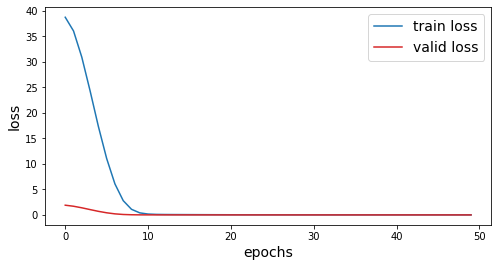

In [6]:
plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss_array, color='tab:blue', label='train loss')
plt.plot(epochs, valid_loss_array, color='tab:red', label='valid loss')
plt.xlabel('epochs', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [7]:
nn_output = None
with torch.no_grad():
    for xtest, ytest in dataloaders['test']:
        nn_output = nn(xtest).reshape(-1,)